In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


The questions that we are going to explore are:

* What is the survival rate of this disaster?
* Are females more likely to survive males?
* Is there a certain age group more likely to survive other age groups?
* Are childern and mothers more likely to be survived than others?
* Did people pay higher fare tend to survive?
* Are there difference of survival rate between differnt ticket classes?
* Who will more likely to survive, families or sigletons? 

After the exploratary data analysis with the above questions, we will conclude with summary of limitations and findings learning from this dataset.

In [2]:
data = pd.read_csv('/kaggle/input/titanic/train.csv')
print("Number of data points: ",len(data))

Number of data points:  891


In [3]:
print("Data fields are: ", data.columns) 

Data fields are:  Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [4]:
print("First rows of data:")
data.iloc[0]

First rows of data:


PassengerId                          1
Survived                             0
Pclass                               3
Name           Braund, Mr. Owen Harris
Sex                               male
Age                               22.0
SibSp                                1
Parch                                0
Ticket                       A/5 21171
Fare                              7.25
Cabin                              NaN
Embarked                             S
Name: 0, dtype: object

**1. What is the survival rate?**

To find the survival rate, we discretize the whole dataset into two categories, one is about people who survived and the other is people who did not. Only less than 40% passengers have survived.

In [5]:
sur = data[data.Survived == 1]
nsur = data[data.Survived == 0]
print("survival rate is:", len(sur) / float(len(data)))

survival rate is: 0.3838383838383838


Let's see what are the correlations between the column factors and whether people survived.

In [6]:
data.corr()["Survived"]

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

Since the column 'Survived' is a binary variable, this correlation might not be able to reflect the true relationships. But from this correlation matrix, Pclass and Fare would be two important factors to investigate, which we will discuss later.

**2. Are females more likely to survive than males?**

Firstly, we create new dataframes that catogorize people based on gender. Then we look at the statistics of different groups.

In [7]:
female = data[data.Sex == 'female']  # number of females
male = data[data.Sex == 'male']  # number of females
fm_sur =  female[female.Survived == 1]  # survived females
fm_not_sur = female[female.Survived == 0]  # non-survived males
m_sur =  male[male.Survived == 1]  # survived males
m_not_sur = male[male.Survived == 0]  # non-survived males

In [8]:
d = {'Total':pd.Series([len(female),len(male)], index = ['female', 'male'] ),\
     'Survived' : (len(fm_sur), len(m_sur)),\
     'Not Survived': (len(fm_not_sur), len(m_not_sur)),\
     'Survive rate': (len(fm_sur)/float(len(female)) , len(m_sur)/float(len(male)))}
pd.DataFrame(d)

,Total,Survived,Not Survived,Survive rate
female,314,233,81,0.742038
male,577,109,468,0.188908


From the table above, we can conclude that females are more likely to be survived because the survive rate is almost four times of that of males. Note that the total number of females are much less than that of the males, but the number of survivals are more than double that of males.

**3. Is there a certain age group more likely to survive other age groups?**

There are 177 missing values in variable 'Age'. In this case, we simply filtered out the missing values for analysis as we could not infer from the other information to find what the missing value would be. The oldest people onboard is 80 years old.

In [9]:
print("Number of data points with Age information: ", len(data) - len(data.Age.dropna()))

Number of data points with Age information:  177


In [10]:
print("Maximum Age: ", max(data.Age.dropna()))

Maximum Age:  80.0


We saw already that gender plays an important role to be a survivor, and females have higher survival rate than males. Let's group the survivors by sex and see how suverviors' age distribution compares to that of victims.

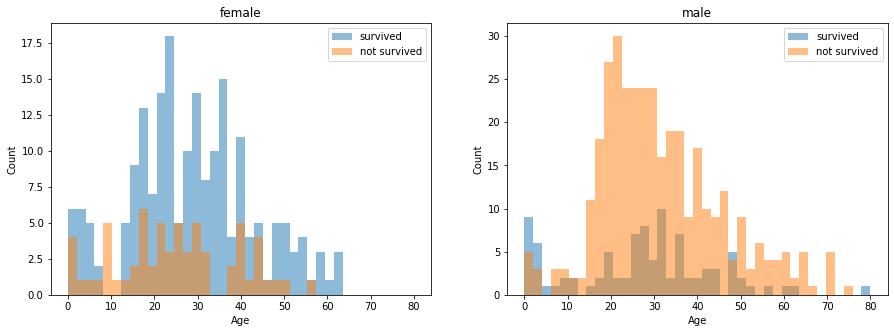

In [11]:
bins = np.linspace(0, 80, 40)
fig = plt.figure(figsize=(15, 5)) 

plt.subplot(1, 2, 1)
plt.hist(fm_sur.Age.dropna(), bins, alpha=0.5, label='survived')
plt.hist(fm_not_sur.Age.dropna(), bins, alpha=0.5, label='not survived')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('female')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.hist(m_sur.Age.dropna(), bins, alpha=0.5, label='survived')
plt.hist(m_not_sur.Age.dropna(), bins, alpha=0.5, label='not survived')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('male')
plt.legend(loc='upper right')
plt.show()

Among both female and male victims we see spikes in age at mid twenties, with small bumps at at early thirties and mid thirties for females. These passengers must be the most brave ones who are willing to sacrifice themselves to save others. Female victims have almost uniform distitrbution among certain age groups, such as ten, early twenties, mid twenties, and early thirties, etc. Male victims' age seems to fall along a bell-shaped distribution peaking at early thirties, except that lots of male kids died in this disaster.

**4. Are childern and mothers more likely to be survived than others?**

Based on the information available, we define a child as a person under 18 years old and a mother is a person who is 

    1) a female, 
    
    2) over 18, 
    
    3) does not have the title ‘Miss’ and 
    
    4) has more than 0 children onboard.

In [12]:
child = data.loc[(data.Parch > 0) & (data.Age < 18)]
data['Title'] = data.Name.apply(lambda x: x[x.find(', ') +2 : x.find('.')])
mother = data.loc[(data.Sex == 'female') & (data.Parch > 0) & (data.Age > 18) & (data.Title != 'Miss')]

In [13]:
d = {'Total':pd.Series([len(child),len(mother)], index = ['child', 'mother'] ),\
     'Survived' : (len(child[child.Survived == 1]), len(mother[mother.Survived == 1])),\
     'Not Survived': (len(child[child.Survived == 0]), len(mother[mother.Survived == 0])),\
     'Survival rate': (len(child[child.Survived == 1])/float(len(child)) , \
                      len(mother[mother.Survived == 1])/float(len(mother)))}
pd.DataFrame(d)

,Total,Survived,Not Survived,Survival rate
child,81,45,36,0.555556
mother,52,37,15,0.711538


This table above makes it pretty clear that mothers have much higher survivor rate than others. Being a child does not hurt, as more than half of kids have survived.

**5. Did people pay higher fare tend to survive?**

Let's examine whether there is a difference between the fare survivors paid and that victims paid.

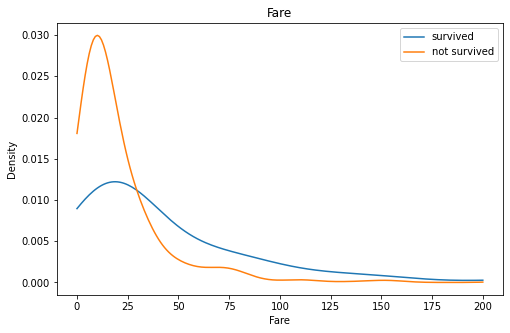

In [14]:
from scipy.stats import gaussian_kde
density1 = gaussian_kde(sur.Fare)
density2 = gaussian_kde(nsur.Fare)

fig = plt.figure(figsize=(8, 5)) 
xs = np.linspace(0,200,200)
plt.plot(xs,density1(xs),label = 'survived')
plt.plot(xs,density2(xs),label = 'not survived')
plt.xlabel('Fare')
plt.ylabel('Density')
plt.title('Fare')
plt.legend(loc='upper right')
plt.show()

The above graph shows that most passengers have paid 15 - 20 £ for tickets. The most common survivors have paid 20 £ while the most common victims's fare is a little lower, which is around 15 £. Interestingly, there are higher chances for passenger to survive if they paid more than 30 £. We already saw the patterns of age among survivors and victims, we are interested in whether there are patterns to look at both fare and age.

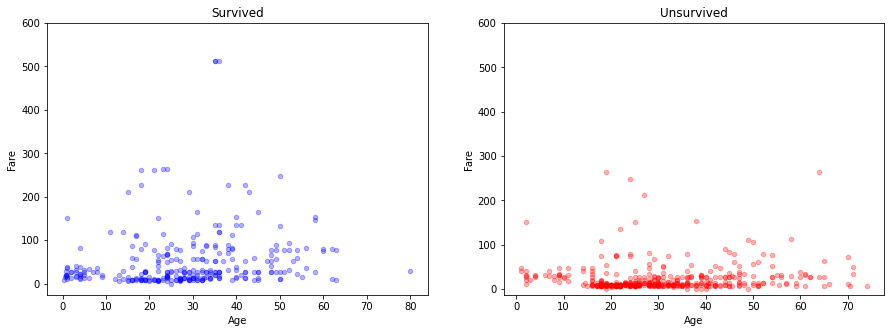

In [15]:
fig = plt.figure(figsize=(15, 5)) 

plt.subplot(1, 2, 1)
plt.scatter(sur.Age , sur.Fare ,s=20, c= 'blue',marker='o', alpha = 0.3,label = 'Survived');
plt.xlabel("Age")
plt.ylabel('Fare')
plt.title('Survived')
plt.yticks(range(0,650,100))

plt.subplot(1, 2, 2)
plt.scatter(nsur.Age , nsur.Fare ,s=20, c= 'red',marker='o', alpha = 0.3,label = 'Unsurvived');
plt.xlabel("Age")
plt.ylabel('Fare')
plt.title('Unsurvived')
plt.yticks(range(0,650,100))
plt.show()

Both survivors and victims cluster around age group twenties to thirties. It is also clear that kid under 10 years old are more likely to be survived. In addition, the fares that survivors paid are more spread while fares that victims paid are more aggregated at lower prices, this confirmed our observation before that people who paied more are more likely to be survived. In fact, the highest fare that non survivors paid is a around 270 £, while passagers who paid more than that are all survived.

**6. Are there difference of survival rate between different ticket classes?**

It is known that Titanic carried some of the wealthiest people in the world, and we alreay knew that people who paid more are more likely to be survived from the above analysis. It is thus interesting to know the difference of survival rate between difference ticket classes.

In [16]:
pclass = pd.concat([pd.DataFrame(data.Pclass.value_counts()),\
                    pd.DataFrame(sur.Pclass.value_counts()), \
                    pd.DataFrame(nsur.Pclass.value_counts())],axis = 1).reset_index()
pclass.columns = ['class','total','survived','non_survived']

In [17]:
pclass['survival_rate'] = pclass.survived / pclass.total
pclass

,class,total,survived,non_survived,survival_rate
0,1,216,136,80,0.629630
1,2,184,87,97,0.472826
2,3,491,119,372,0.242363


Therefore, first class passengers got priority to be saved when facing disasters. The survival rate is highest among first class passengers while passengers from third ticket class suffer from much lower survival rate.

**7. who will more likely to survive, families or sigletons?**

The last question we want to look at is whether sigletons are more likely to survive than people have families on board. First, we’re going to make a family size variable based on number of siblings/spouse(s) and number of children/parents.

In [18]:
sur.loc[:,'family'] = sur.loc[:,'Parch'] + sur.loc[:,'SibSp']
nsur.loc[:,'family'] = nsur.loc[:,'Parch'] + nsur.loc[:,'SibSp']

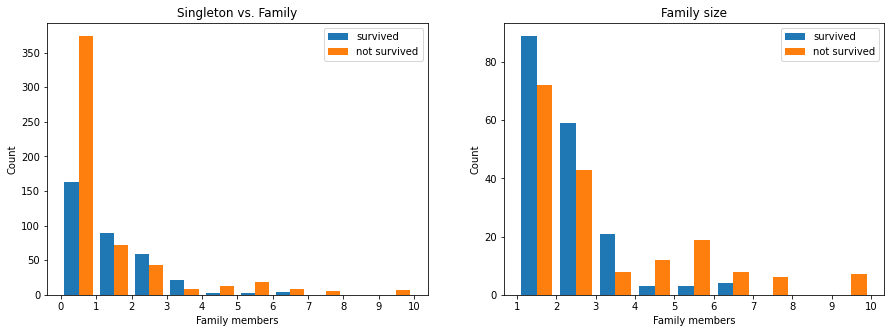

In [19]:
fig = plt.figure(figsize=(15, 5)) 
bins = np.linspace(0,10,11)

plt.subplot(1, 2, 1)
plt.hist((sur['family'], nsur['family']), bins, label = ("survived", "not survived"))
plt.xlabel('Family members')
plt.ylabel('Count')
plt.xticks(range(11))
plt.title('Singleton vs. Family')
plt.legend(loc='upper right')

bins2 = np.linspace(1,10,10)
plt.subplot(1, 2, 2)
plt.hist((sur[sur.family >= 1].family, nsur[nsur.family >= 1].family), bins2, label = ("survived", "not survived"))
plt.xlabel('Family members')
plt.ylabel('Count')
plt.title('Family size')
plt.xticks(range(1,11))
plt.legend(loc='upper right')
plt.show()

The chart on the left shows that the most common victims are sigletons. More than half sigletons are victims. The figure on the right examines people who has families a little closer: people who have small families, such as families with two to four family members are more likely to survive, while people who have large families, meaning more than five members are more likely to be victims. To summarize, there’s a survival penalty among singletons and large families, but a benefit for customers in small families.

**Conclusion**
This analysis is limited by the sample size of the data and the available information of each passagers. We have a total of 891 data points, but 177 of them do not have age information. Despite the data limitations, we gained some insights from analyzing this dataset:

* Some groups of people were more likely to survive than others, such as women, children, and the upper-class.
* There is a survival penalty among people who are in their mid twenties and early thirties.
* Singletons and large families are more likely to be victims, while passengers in small families are more likely to survive.